# Prelude

## Imports

In [18]:
# scientific libraries
import numpy as np  # vectors/matrices and math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt  # plotting library
from matplotlib import cm  # color maps
import plotly  # trying neurons PlotShape class to visualize with plotly backend

# general libraries
import os  # operating system
import h5py as h5 # hierarchical data format

from neuron import h
h.load_file("stdgui.hoc")  # headless, still sets up environment

1.0

## Jupyter config
Three possibilites for interactive figures are included, hopefully one of them works for you. `qt` is for separate windows like you would have running `pyplot` from a script. If all `%matplotlib` options are commented out, you'll have the usual non-interactive style inline plots.

In [2]:
# matplotlib display directives (only uncomment one)
# =================================================
# interactive in notebook directives
# -----------------------------------------------
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# -----------------------------------------------
# interactive outside of notebook directive (qt)
# -----------------------------------------------
# %matplotlib qt 
# =================================================

# pyplot parameters
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

## Directory paths

In [3]:
base_path = ""
fig_path = os.path.join(base_path, "figs")
os.makedirs(fig_path, exist_ok=True)

## Utility functions

In [4]:
def nrn_section(name):
    """Create NEURON hoc section, and return a corresponding python object."""
    h("create " + name)
    return h.__getattribute__(name)

def build_stim(loc=0.5):
    """Return basic initialized NetStim object."""
    stim = h.NetStim(loc)
    stim.interval = 0
    stim.number = 1
    stim.noise = 0
    return stim

def clean_axes(
    axes,
    remove_spines=["right", "top"],
    ticksize=11.0,
    spine_width=None,
    tick_width=None,
):
    """A couple basic changes I often make to pyplot axes. If input is an
    iterable of axes (e.g. from plt.subplots()), apply recursively."""
    if hasattr(axes, "__iter__"):
        for a in axes:
            clean_axes(
                a,
                remove_spines=remove_spines,
                ticksize=ticksize,
                tick_width=tick_width,
                spine_width=spine_width,
            )
    else:
        if spine_width is not None and tick_width is None:
            tick_width = spine_width
        for r in remove_spines:
            axes.spines[r].set_visible(False)
        axes.tick_params(
            axis="both",
            which="both",  # applies to major and minor
            **{r: False for r in remove_spines},  # remove ticks
            **{"label%s" % r: False for r in remove_spines},  # remove labels
            width=tick_width,
        )
        for ticks in axes.get_yticklabels():
            ticks.set_fontsize(ticksize)
        for ticks in axes.get_xticklabels():
            ticks.set_fontsize(ticksize)
        if spine_width is not None:
            for s in ["top", "bottom", "left", "right"]:
                axes.spines[s].set_linewidth(spine_width)
            
def nearest_index(arr, v):
    """Index of value closest to v in ndarray `arr`"""
    return np.argmin(np.abs(arr - v))

# Modelling

## Build ball and stick

**nseg**: This specifies the number of compartments in a section. Computations (and connections to other sections) are done at the ends (locations 0.0 and 1.0) of each section, as well as the middle of each segment/compartment. So `nseg=1` lets us record from locations 0.0, 0.5, and 1.0. So, if we want to record at many locations along a section, we need to set `nseg` accordingly. Note that if you go up by factors of 3 that the centres are preserved. For more info see the [neuron geometry docs](https://www.neuron.yale.edu/neuron/static/new_doc/modelspec/programmatic/topology/geometry.html).

In [5]:
e_pas = -60

soma = nrn_section("soma")
soma.L = 10  # length (µm)
soma.diam = 10 # diameter (µm)
soma.nseg = 1  # number of segments 
soma.Ra = 150  # axial resistance (10^6 ohms [megaohms])
soma.insert("pas")  # passive membrane properties
soma.e_pas = e_pas  # leak reversal (mV)
soma.g_pas = 0.0001667  # leak conductance (S/cm^2)

dend = nrn_section("dend")
dend.L = 150  # length (µm)
dend.diam = 0.5  # diameter (µm)

dend.nseg = 149  # number of segments
dend.Ra = 150  # axial resistance (10^6 ohms [megaohms])
dend.insert("pas")  # passive membrane properties
dend.e_pas = e_pas  # leak reversal (mV)
dend.g_pas = 0.0001667  # distributed leak conductance (S/cm^2)

dend.connect(soma)  # attach loc 0 of dend to loc 1 of soma
syn_sec = dend  # ref to dend section

### Visualize the model

Unfortunately only plotly seems to work right now, and I can't get the diameters of the model to show, so this may as well be skipped out for now.

In [6]:
if 0:
    plotly_mode = True # plotly mostly works for me, pyplot seems to be bugged
    dend.v = 0
    soma.v = 0
    nrn_sl = h.SectionList([soma, dend])
    nrn_ps = h.PlotShape(nrn_sl, False)  # False tells h.PlotShape not to use NEURON's gui
    nrn_ps.show(0)  # try to show section diameter (doesn't seem to work)
    # nrn_ps.scale(-80, 40)
    # nrn_ps.variable('v')
    if plotly_mode:
        nrn_ps.plot(plotly, cmap=cm.jet).show()
    else:
        nrn_ps.plot(plt, cmap=cm.jet)

## Place synapses

In [7]:
# base_w = 0.000313
base_w = 0.01
syn_loc = 1.0

# push the section we want our synapse on onto the stack
syn_sec.push()
# when we make synapses, they are placed onto the section at the top of the stack

# Excitatory synapse
e_stim = build_stim(loc=syn_loc)  # make a basic NetStim to drive single synaptic events
e_syn = h.Exp2Syn(syn_loc)  # make a bi-exponential synapse (specifiable rise and decay)
e_syn.tau1 = 0.14  # rise time-constant
e_syn.tau2 = 0.3  # decay time-constant
e_syn.e = 0.0  # reversal potential
e_weight = base_w  # point conductance (µS)
# connect NetStim and Exp2Syn into a complete synapse with NetCon(source, target, threshold, delay, weight)
e_con = h.NetCon(e_stim, e_syn, 0, 0, e_weight)  # complete synapse 

# Inhibitory synapse
i_stim = build_stim(loc=syn_loc)  # make a basic NetStim to drive single synaptic events
i_syn = h.Exp2Syn(syn_loc)  # make a bi-exponential synapse (specifiable rise and decay)
i_syn.tau1 = 0.14  # rise time-constant
i_syn.tau2 = 4.0  # decay time-constant
i_syn.e = -60.0  # reversal potential
i_weight = base_w * 2  # point conductance (µS)
# connect NetStim and Exp2Syn into a complete synapse with NetCon(source, target, threshold, delay, weight)
i_con = h.NetCon(i_stim, i_syn, 0, 0, i_weight)  # complete synapse 

h.pop_section()  # pop our synapse section off of the stack

1.0

## Setup recordings

We use `h.Vector` to collect variables over the course of a run of the model.

In [8]:
class Rig:
    def __init__(self):
        # soma membrane voltage
        self.soma_v = h.Vector()  # create an empty vector
        self.soma_v.record(soma(0.5)._ref_v)  # record the voltage at loc 0.5 (middle) of the soma compartment
        
        # dendritic membrane voltage
        seg_frac = 1 / dend.nseg
        mid0 = seg_frac / 2
        self.dend_locs = np.array([0.0] + [mid0 + i * seg_frac for i in range(dend.nseg)] + [1.0]) 
        self.syn_dists = (syn_loc - self.dend_locs) * dend.L  # negative is further away from soma 
        self.dend_vs = [h.Vector() for _ in self.dend_locs]
        self.dend_vs[0].record(dend(0.0)._ref_v)  # start of dendrite at soma
        for i, vec in enumerate(self.dend_vs[1:-1]):
            vec.record(dend(mid0 + i * seg_frac)._ref_v)  # middle of each segment
        self.dend_vs[-1].record(dend(1.0)._ref_v)  # end of dendrite
        
        # excitatory synapse vectors
        self.syn_vs = {"e": {}, "i": {}}
        self.syn_vs["e"]["i"] = h.Vector()
        self.syn_vs["e"]["i"].record(e_syn._ref_i)  # excitatory current
        self.syn_vs["e"]["g"] = h.Vector()
        self.syn_vs["e"]["g"].record(e_syn._ref_g)  # excitatory conductance
        
        # inhibitory synapse vectors
        self.syn_vs["i"]["i"] = h.Vector()
        self.syn_vs["i"]["i"].record(i_syn._ref_i)  # inhibitory current
        self.syn_vs["i"]["g"] = h.Vector()
        self.syn_vs["i"]["g"].record(i_syn._ref_g)  # inhibitory conductance
        
        self.soma = []  # soma voltage recordings
        self.dends = []  # dendritic voltage recordings
        self.syns = {k: {"i": [], "g": []} for k in ["e", "i"]}
    
    def clear_recs(self):
        self.soma = []
        self.dends = []
        for k in self.syns.keys():
            for r in self.syns[k].keys():
                self.syns[k][r] = []
                
    def dump_recs(self):
        soma = np.stack(self.soma, axis=0)  # dimensions: (condition, time)
        dends = np.stack(self.dends, axis=0)  # dends dimensions: (condition, location, time)
        syns = {}
        for k in self.syns.keys():
            syns[k] = {}
            for r in self.syns[k].keys():
                syns[k][r] = np.stack(self.syns[k][r], axis=0)
        
        return soma, dends, syns
    
    def push_recs(self):
        self.soma.append(np.array(self.soma_v))
        self.dends.append(np.stack(self.dend_vs, axis=0))
        for syn in self.syn_vs.keys():
            for k in self.syns[syn].keys():
                self.syns[syn][k].append(np.array(self.syn_vs[syn][k]))
                
    def clear_vecs(self):
        self.soma_v.resize(0)
        for vec in self.dend_vs:
            vec.resize(0)
        for vecs in self.syn_vs.values():
            for vec in vecs.values():
                vec.resize(0)
        
rig = Rig()

def run(t):
    """Helper function to run the model and collect data """
    h.init()  # initialize the neuron model (resting potentials etc)
    e_stim.start = t  # start time for excitatory conductance
    i_stim.start = i_time  # start time for inhibitory conductance
    rig.clear_vecs()  # empty out the recording vectors
    h.run()  # run the model from t=0 to h.tstop
    rig.push_recs()  # collect recordings from the filled vectors

## Initialize model

In [9]:
tstop = 100  # simulation stop time / duration (ms)
dt = 0.1  # time step (ms)

h.finitialize()
h.tstop = tstop
h.steps_per_ms = int(1 / dt)
h.dt = dt
h.v_init = -60  # initialization membrane voltage
h.celsius = 36.9

n_pts = int(tstop / dt + 1)
xaxis = np.linspace(0, tstop, n_pts)

## Run simulation with a range of excitation onset timings

In [22]:
n_e_times = 40  # number of excitation onsets to test
e_step = 1  # time (ms) between each tested onset
e_offset = 0  # base onset time for excitation
i_time = 10  # static onset for inhibition
e_times = np.arange(n_e_times) * e_step + e_offset  # range of excitation onset times
    
# run shuning experiment
rig.clear_recs()
for t in e_times: 
    run(t)
    
# v_mat = somatic recordings; shape: (n_e_times, n_pts)
# dend_mat = dendritic recordings; shape: (n_e_times, dend.nseg + 2, n_pts)
# syn_mats = dictionary of synaptic currents and conductances {synapse e/i: {i/g: (n_e_times, n_pts)}}
v_mat, dend_mat, syn_mats = rig.dump_recs()

# run experiment with inhibition turned off (no shunt)
i_con.weight[0] = 0  # set inhibitory conductance to zero
rig.clear_recs()
for t in e_times:
    run(t)
    
i_con.weight[0] = i_weight  # reset inhibitory conducance to default
v_mat_no_inh, dend_mat_no_inh, syn_mats_no_inh = rig.dump_recs() 
rig.clear_recs()

## Save data to file

Numpy provides a function [savetxt](https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html) which can be used to easily save 1D and 2D vectors/matrices to **csv** (comma separated value) files which can be loaded into spreadsheet programs or IgorPro. If you want to save multidimensional (> 2D) data without breaking it up into <= 2-dimensional chunks or flattening the data to fit into the **csv** format, [hdf5](https://www.neonscience.org/resources/learning-hub/tutorials/about-hdf5#:~:text=The%20Hierarchical%20Data%20Format%20version,large%2C%20complex%2C%20heterogeneous%20data.) files are an option that modern IgorPro understands.

In [21]:
save_data = False
if save_data:
    # 2-dimensional matrices of somatic membrane voltage (n_e_times columns, n_pts rows)
    np.savetxt(os.path.join(base_path, "soma_vm.csv"), v_mat)
    np.savetxt(os.path.join(base_path, "soma_vm_no_inhib.csv"), v_mat_no_inh)
    
    # 3-dimensional matrices of dendritic membrane voltage (shape: n_e_times, dend.nseg + 2, n_pts)
    # by using `with ... as name:`, we ensure that the file we open is closed at the end of the block
    with h5.File(os.path.join(base_path, "dendritic_vm.h5"), mode="w") as hdf:
        hdf.create_dataset("with_inhib", data=dend_mat)
        hdf.create_dataset("without_inhib", data=dend_mat_no_inh)
        
    # hdf5 archives are hierarchical, so we can organize them like we would a dict in python
    with h5.File(os.path.join(base_path, "synapses.h5"), mode="w") as hdf:
        for cond, data in [("with_inhib", syn_mats), ("without_inhib", syn_mats_no_inh)]:
            cond_grp = hdf.create_group(cond)
            for name, key in [("exc", "e"), ("inh", "i")]:
                syn_grp = cond_grp.create_group(name)
                syn_grp.create_dataset("i", data=syn_mats[key]["i"])
                syn_grp.create_dataset("g", data=syn_mats[key]["g"])
        

# Analysis

## Visualize the timing dependence of shunting

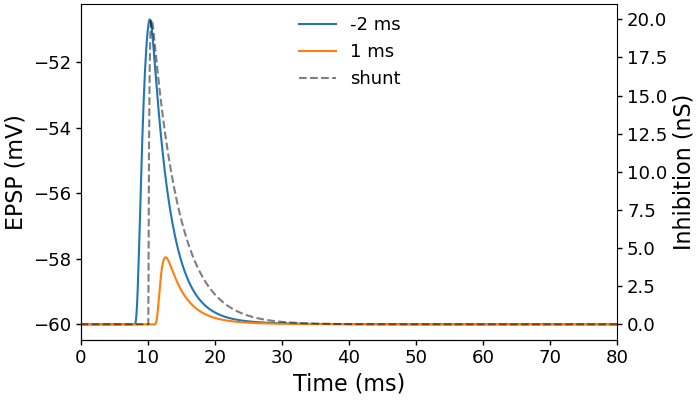

In [11]:
show_idxs = [8, 11]  # exc timing indices to display (first dimension of the recording matrices)
timing_fig, timing_ax = plt.subplots(1, figsize=(7, 4))
timing_ax_g = timing_ax.twinx()  # add right y-axis for conductance (different units/scale)
timing_ax_g.plot(xaxis, syn_mats["i"]["g"][0] * 1e3, c="black", linestyle="--", alpha=0.5, label="shunt")
for i in show_idxs:
    timing_ax.plot(xaxis, v_mat[i], label="%i ms" % (e_times[i] - i_time))

timing_ax.set_xlim(0, 80)
timing_ax.set_xlabel("Time (ms)", fontsize=16)
timing_ax.set_ylabel("EPSP (mV)", fontsize=16)
timing_ax_g.set_ylabel("Inhibition (nS)", fontsize=16)
timing_fig.legend(frameon=False, fontsize=13, loc="upper center")
clean_axes(timing_ax, ticksize=13)
clean_axes(timing_ax_g, ticksize=13, remove_spines=[])
timing_fig.set_layout_engine("compressed")

Fancy plot showing excitatory (blue) and inhibitory (red) conductances alongside the resulting membrane voltage (solid black) and the membrane voltage that would have been if there was no inhibition (dashed translucent black)

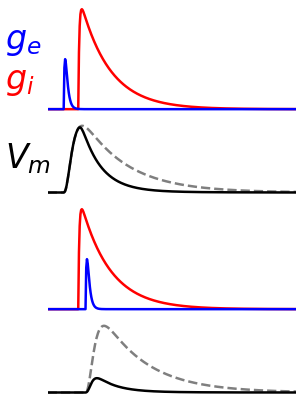

In [12]:
early_idx = 8
shunt_idx = 11

gspec = {"height_ratios": [0.3, 0.2, 0.3, 0.2]}
lw = 1.8
fancy_timing_fig, fancy_timing_ax = plt.subplots(4, 1, sharex=True, figsize=(3, 4), gridspec_kw=gspec)

fancy_timing_ax[0].plot(xaxis, syn_mats["i"]["g"][early_idx], c="red", lw=lw)
fancy_timing_ax[0].plot(xaxis, syn_mats["e"]["g"][early_idx], c="blue", lw=lw)
fancy_timing_ax[1].plot(xaxis, v_mat_no_inh[early_idx], c="black", alpha=0.5, lw=lw, linestyle="--")
fancy_timing_ax[1].plot(xaxis, v_mat[early_idx], c="black", lw=lw)
fancy_timing_ax[2].plot(xaxis, syn_mats["i"]["g"][shunt_idx], c="red", lw=lw)
fancy_timing_ax[2].plot(xaxis, syn_mats["e"]["g"][shunt_idx], c="blue", lw=lw)
fancy_timing_ax[3].plot(xaxis, v_mat_no_inh[shunt_idx], c="black", alpha=0.5, lw=lw, linestyle="--")
fancy_timing_ax[3].plot(xaxis, v_mat[shunt_idx], c="black", lw=lw)

fancy_timing_ax[0].text(0, 0.012, "$g_e$", fontsize=24, c="blue")
fancy_timing_ax[0].text(0, 0.004, "$g_i$", fontsize=24, c="red")
fancy_timing_ax[1].text(0, -56.5, "$V_m$", fontsize=24, c="black")
fancy_timing_ax[-1].set_xlim(6, 40)
for ax in fancy_timing_ax:
    clean_axes(ax, remove_spines=["left", "right", "top", "bottom"])
    
fancy_timing_fig.set_layout_engine("compressed")
fancy_timing_fig.savefig(os.path.join(fig_path, "shunting_ex.svg"), bbox_inches="tight")

## Visualize decay of the EPSP along the dendrite

### Example EPSPs

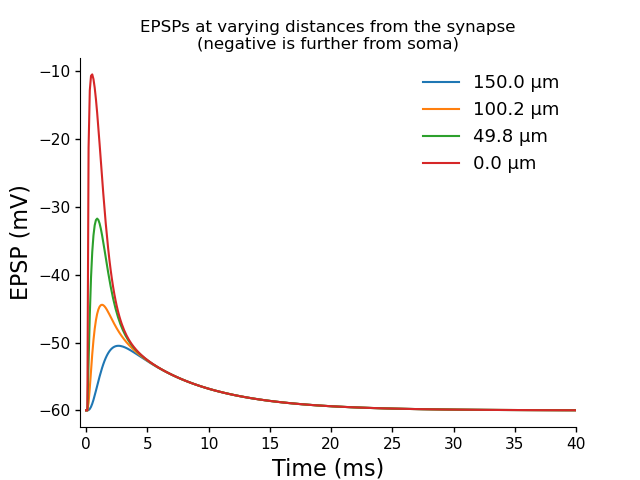

In [13]:
show_loc_idxs = [0, 50, 100, 150]  # location indices into the recording matrix (2nd dimension)
multi_loc_fig, multi_loc_ax = plt.subplots(1)
for i in show_loc_idxs:
    multi_loc_ax.plot(xaxis, dend_mat_no_inh[0, i], label="%.1f µm" % rig.syn_dists[i])
    
multi_loc_ax.set_title("EPSPs at varying distances from the synapse\n(negative is further from soma)")
multi_loc_ax.set_xlim(-0.5, 40)
multi_loc_ax.set_xlabel("Time (ms)", fontsize=16)
multi_loc_ax.set_ylabel("EPSP (mV)", fontsize=16)
multi_loc_ax.legend(frameon=False, fontsize=13)
clean_axes(multi_loc_ax)

### Peak membrane voltage along the dendrite

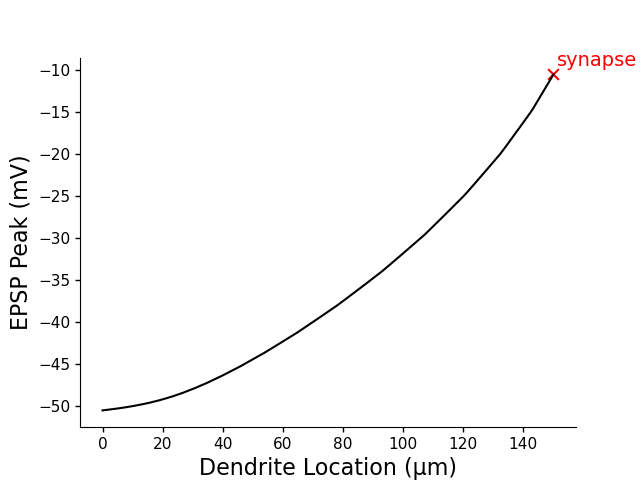

In [14]:
dend_peaks = np.max(dend_mat_no_inh[0], axis=-1)  # max depolarization for each location
dend_xaxis = dend.L * rig.dend_locs  # use fractional [0-1] locations to get µm coordinates

dend_decay_fig, dend_decay_ax = plt.subplots(1)
dend_decay_ax.plot(dend_xaxis, dend_peaks, c="black")

# mark location of synapse
syn_loc_idx = nearest_index(rig.dend_locs, syn_loc)
syn_x = dend_xaxis[syn_loc_idx]
syn_y = dend_peaks[syn_loc_idx]
dend_decay_ax.scatter(syn_x, syn_y, c="red", marker="x", s=60)
dend_decay_ax.text(syn_x + 1, syn_y + 1, "synapse", c="red", fontsize="14")

dend_decay_ax.set_xlabel("Dendrite Location (µm)", fontsize=16)
dend_decay_ax.set_ylabel("EPSP Peak (mV)", fontsize=16)
clean_axes(dend_decay_ax)

### Calculate length constant

Calculate the [length constant](https://en.wikipedia.org/wiki/Length_constant) (λ) of voltage decay along the dendrite using the equation:
$$\Large{y = V_{max}{e^{\frac{-x}{λ}}}}$$

In [15]:
epsp_amps = dend_peaks - soma.e_pas  # peak positive voltage deflection

# define our decay function: x value first, followed by each parameter
decay_fun = lambda x, vmax, lam: vmax * np.exp(-x / lam)  # vmax * e^(-x/tau)

# find the parameters Vmax and λ with initial guesses optionally provided by `p0=(Vmax, λ)`
(vmax, lam), pcov = curve_fit(decay_fun, rig.syn_dists, epsp_amps, p0=(50, 50))

# calculate y (EPSP amplitude) values using the fit parameters
decay_fit = decay_fun(rig.syn_dists, vmax, lam) 

print("Fit decay parameters")
print("---------------------")
print("vmax = %f mV\nlambda = %f µm" % (vmax, lam))

Fit decay parameters
---------------------
vmax = 49.330165 mV
lambda = 87.689661 µm


### Compare fit to EPSP amplitude data

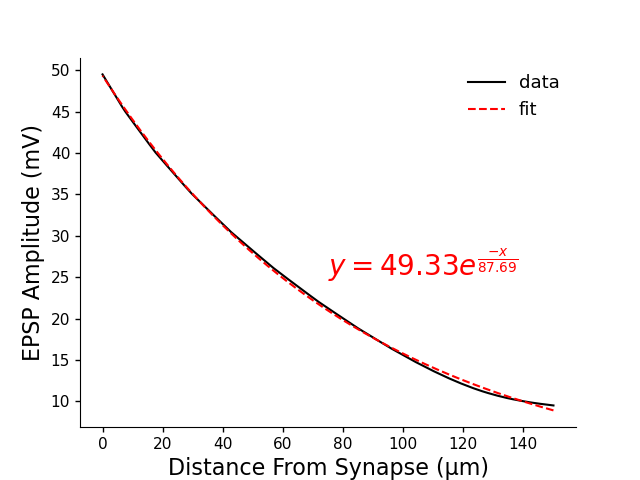

In [16]:
dist_decay_fig, dist_decay_ax = plt.subplots(1)
dist_decay_ax.plot(rig.syn_dists, epsp_amps, c="black", label="data")
dist_decay_ax.plot(rig.syn_dists, decay_fit, c="red", linestyle="--", label="fit")

fit_txt_x = (rig.syn_dists.max() - rig.syn_dists.min()) / 2
fit_txt_y = (epsp_amps.max() - epsp_amps.min()) / 2 + 5
dist_decay_ax.text(
    fit_txt_x, 
    fit_txt_y, 
    r"$y = {%.2f}{e^{\frac{-x}{%.2f}}}$" % (vmax, lam),
    fontdict={"size": 20, "c": "red"}
)

dist_decay_ax.set_xlabel("Distance From Synapse (µm)", fontsize=16)
dist_decay_ax.set_ylabel("EPSP Amplitude (mV)", fontsize=16)
dist_decay_ax.legend(frameon=False, fontsize=13)
clean_axes(dist_decay_ax)